In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

# Defining the paths
data_dir = '/kaggle/input/histopathologic-cancer-detection/train'
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Loading the labels
labels_df = pd.read_csv(labels_path)

# Setting a threshold for percentage of identical pixels
threshold_percentage = 0.95

# Using Transform to convert PIL image to PyTorch tensor and apply center crop (32x32)
transform = transforms.Compose([
    transforms.CenterCrop(32),  # Crop the center 32x32 pixels
    transforms.ToTensor()       # Convert the image to a tensor
])

# Device selection (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to check if the image has a majority of identical pixels (to identify noisy images)
def is_noisy_image(image_tensor, threshold_percentage):
    img_flattened = image_tensor.view(-1, image_tensor.shape[-1])
    
    unique_pixels, counts = img_flattened.unique(dim=0, return_counts=True)
    
    # Find the percentage of the most common pixel
    max_pixel_percentage = counts.max().item() / counts.sum().item()
    
    return max_pixel_percentage >= threshold_percentage

# List to store the IDs of non-noisy images and noisy images
valid_image_ids = []
noisy_image_ids = []

# Process images and remove noisy ones before creating the dataset
total_images = len(labels_df)

# Using the Progress bar to monitor the progress of the loop
with tqdm(total=total_images, desc="Processing Images") as pbar:
    for idx in range(total_images):
        img_id = labels_df.iloc[idx]['id']
        img_path = os.path.join(data_dir, img_id + '.tif')
        
        # Load the image
        img = Image.open(img_path)
        
        # Apply the transformation to center crop and convert the image to a tensor
        img_tensor = transform(img).to(device)
        
        # Check if the image is noisy using the provided noise removal function
        if not is_noisy_image(img_tensor, threshold_percentage):
            valid_image_ids.append(img_id)
        else:
            noisy_image_ids.append(img_id)  # Store noisy image IDs
        
        pbar.update(1)

# Filtering out the labels of the valid images
clean_labels_df = labels_df[labels_df['id'].isin(valid_image_ids)]

# Saving the cleaned labels file
clean_labels_df.to_csv('clean_train_labels.csv', index=False)

print(f"Total valid images: {len(valid_image_ids)}")
print(f"Total noisy images: {len(noisy_image_ids)}")


Using device: cuda


Processing Images: 100%|██████████| 220025/220025 [30:24<00:00, 120.57it/s]


Total valid images: 219996
Total noisy images: 29


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your labels file
#labels_path = '/kaggle/working/clean_train_labels.csv'
labels_path = '/kaggle/input/hcd-clean/clean_train_labels.csv'
labels_df = pd.read_csv(labels_path)

# Define total number of samples
total_samples = 219996

# Define subset sizes based on percentages
subset_1_size = int(total_samples * 0.20)  # 20%
subset_2_size = int(total_samples * 0.40)  # 40%
subset_3_size = int(total_samples * 0.60)  # 60%

# Subset 1 (20% of total dataset)
subset_1, _ = train_test_split(labels_df, train_size=subset_1_size, stratify=labels_df['label'], random_state=42)

# Subset 2 (40% of total dataset)
subset_2, _ = train_test_split(labels_df, train_size=subset_2_size, stratify=labels_df['label'], random_state=42)

# Subset 3 (60% of total dataset)
subset_3, _ = train_test_split(labels_df, train_size=subset_3_size, stratify=labels_df['label'], random_state=42)

# Save the subsets (optional)
subset_1.to_csv('subset_1.csv', index=False)
subset_2.to_csv('subset_2.csv', index=False)
subset_3.to_csv('subset_3.csv', index=False)

# Print the sizes and counts of each subset
for i, subset in enumerate([subset_1, subset_2, subset_3], start=1):
    counts = subset['label'].value_counts()
    non_cancerous_count = counts.get(0, 0)  # Assuming 0 indicates non-cancerous
    cancerous_count = counts.get(1, 0)      # Assuming 1 indicates cancerous
    print(f"Subset {i} size: {len(subset)}")
    print(f"Non-cancerous count in Subset {i}: {non_cancerous_count}")
    print(f"Cancerous count in Subset {i}: {cancerous_count}\n")


Subset 1 size: 43999
Non-cancerous count in Subset 1: 26176
Cancerous count in Subset 1: 17823

Subset 2 size: 87998
Non-cancerous count in Subset 2: 52351
Cancerous count in Subset 2: 35647

Subset 3 size: 131997
Non-cancerous count in Subset 3: 78527
Cancerous count in Subset 3: 53470



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load each subset (assuming you've saved them as CSV files)
subset_1 = pd.read_csv('/kaggle/working/subset_1.csv')
subset_2 = pd.read_csv('/kaggle/working/subset_2.csv')
subset_3 = pd.read_csv('/kaggle/working/subset_3.csv')

# Function to split a dataset into train and temporary (for validation and test)
def split_dataset(df, train_ratio=0.7):
    # Split into train and temp (val + test)
    train_df, temp_df = train_test_split(df, train_size=train_ratio, stratify=df['label'], random_state=42)
    return train_df, temp_df

# Function to create validation and test sets with specified label distributions
def create_val_test_sets(temp_df):
    # Define the desired proportions
    cancerous_ratio = 0.2  # 20%
    non_cancerous_ratio = 0.8  # 80%

    # Separate cancerous and non-cancerous samples
    cancerous_samples = temp_df[temp_df['label'] == 1]
    non_cancerous_samples = temp_df[temp_df['label'] == 0]

    # Calculate sizes for validation and test sets (each should be half of the total size)
    val_test_size = len(temp_df) * 0.5

    # Number of samples needed for validation and test sets
    val_test_cancerous_count = int(val_test_size * cancerous_ratio / 2)
    val_test_non_cancerous_count = int(val_test_size * non_cancerous_ratio / 2)

    # Sample the required number of cancerous and non-cancerous samples for validation
    val_cancerous = cancerous_samples.sample(n=val_test_cancerous_count, random_state=42)
    val_non_cancerous = non_cancerous_samples.sample(n=val_test_non_cancerous_count, random_state=42)
    val_df = pd.concat([val_cancerous, val_non_cancerous])

    # Remove the sampled validation data from the original data
    remaining_cancerous = cancerous_samples.drop(val_cancerous.index)
    remaining_non_cancerous = non_cancerous_samples.drop(val_non_cancerous.index)

    # Sample the required number of cancerous and non-cancerous samples for test
    test_cancerous = remaining_cancerous.sample(n=val_test_cancerous_count, random_state=42)
    test_non_cancerous = remaining_non_cancerous.sample(n=val_test_non_cancerous_count, random_state=42)
    test_df = pd.concat([test_cancerous, test_non_cancerous])

    # The remaining data is used for training
    train_df = pd.concat([remaining_cancerous.drop(test_cancerous.index), remaining_non_cancerous.drop(test_non_cancerous.index)])

    return train_df, val_df, test_df


# Split Subset 1
train_1a, temp_1 = split_dataset(subset_1)
train_1b, val_1, test_1 = create_val_test_sets(temp_1)
train_1 = pd.concat([train_1a, train_1b])

# Ensure that the indices are reset to avoid duplicates
train_1 = train_1.reset_index(drop=True)
val_1 = val_1.reset_index(drop=True)
test_1 = test_1.reset_index(drop=True)

# Split Subset 2
train_2a, temp_2 = split_dataset(subset_2)
train_2b, val_2, test_2 = create_val_test_sets(temp_2)
train_2 = pd.concat([train_2a, train_2b])

# Ensure that the indices are reset to avoid duplicates
train_2 = train_2.reset_index(drop=True)
val_2 = val_2.reset_index(drop=True)
test_2 = test_2.reset_index(drop=True)

# Split Subset 3
train_3a, temp_3 = split_dataset(subset_3)
train_3b, val_3, test_3 = create_val_test_sets(temp_3)
train_3 = pd.concat([train_3a, train_3b])

# Ensure that the indices are reset to avoid duplicates
train_3 = train_3.reset_index(drop=True)
val_3 = val_3.reset_index(drop=True)
test_3 = test_3.reset_index(drop=True)


In [3]:
# Function to display cancerous and non-cancerous sample counts
def display_sample_counts(train_df, val_df, test_df, subset_name):
    train_cancerous = len(train_df[train_df['label'] == 1])
    train_non_cancerous = len(train_df[train_df['label'] == 0])

    val_cancerous = len(val_df[val_df['label'] == 1])
    val_non_cancerous = len(val_df[val_df['label'] == 0])

    test_cancerous = len(test_df[test_df['label'] == 1])
    test_non_cancerous = len(test_df[test_df['label'] == 0])

    print(f"{subset_name} - Train: {len(train_df)} (Cancerous: {train_cancerous}, Non-cancerous: {train_non_cancerous})")
    print(f"{subset_name} - Val: {len(val_df)} (Cancerous: {val_cancerous}, Non-cancerous: {val_non_cancerous})")
    print(f"{subset_name} - Test: {len(test_df)} (Cancerous: {test_cancerous}, Non-cancerous: {test_non_cancerous})\n")

# Display the sample counts for all subsets
display_sample_counts(train_1, val_1, test_1, "Subset 1")
display_sample_counts(train_2, val_2, test_2, "Subset 2")
display_sample_counts(train_3, val_3, test_3, "Subset 3")

# Optionally, save the split data
train_1.to_csv('train_1.csv', index=False)
val_1.to_csv('val_1.csv', index=False)
test_1.to_csv('test_1.csv', index=False)

train_2.to_csv('train_2.csv', index=False)
val_2.to_csv('val_2.csv', index=False)
test_2.to_csv('test_2.csv', index=False)

train_3.to_csv('train_3.csv', index=False)
val_3.to_csv('val_3.csv', index=False)
test_3.to_csv('test_3.csv', index=False)


Subset 1 - Train: 37399 (Cancerous: 16503, Non-cancerous: 20896)
Subset 1 - Val: 3300 (Cancerous: 660, Non-cancerous: 2640)
Subset 1 - Test: 3300 (Cancerous: 660, Non-cancerous: 2640)

Subset 2 - Train: 74798 (Cancerous: 33007, Non-cancerous: 41791)
Subset 2 - Val: 6600 (Cancerous: 1320, Non-cancerous: 5280)
Subset 2 - Test: 6600 (Cancerous: 1320, Non-cancerous: 5280)

Subset 3 - Train: 112197 (Cancerous: 49510, Non-cancerous: 62687)
Subset 3 - Val: 9900 (Cancerous: 1980, Non-cancerous: 7920)
Subset 3 - Test: 9900 (Cancerous: 1980, Non-cancerous: 7920)



In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_id = self.data.iloc[index, 0] 
        img_path = f'/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif'

        image = Image.open(img_path)
        
        label = int(self.data.iloc[index, 1])

        if self.transform:
            image = self.transform(image)
        
        # Convert PIL image to a NumPy array
        image = np.array(image)

        return image, label


In [5]:
# Define the transformations
transform = transforms.Compose([
    transforms.CenterCrop(32),  # Center crop to 32x32 pixels
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    #transforms.Normalize(mean, std)  # Normalize using the calculated mean and std
])

# Initialize the dataset
dataset = CustomDataset('/kaggle/working/val_1.csv', transform=transform)

# Access a sample image and label
img, label = dataset[0]
print(f"Image tensor size: {img.shape}")
print(f"Label: {label}")


Image tensor size: (3, 32, 32)
Label: 1


In [6]:
# Define batch size
batch_size = 64

# Create train and test data loaders
train_dataset_1 = CustomDataset('/kaggle/working/train_1.csv', transform=transform)
val_dataset_1 = CustomDataset('/kaggle/working/val_1.csv', transform=transform)
test_dataset_1 = CustomDataset('/kaggle/working/test_1.csv', transform=transform)
 
train_dataset_2 = CustomDataset('/kaggle/working/train_2.csv', transform=transform)
val_dataset_2 = CustomDataset('/kaggle/working/val_2.csv', transform=transform)
test_dataset_2 = CustomDataset('/kaggle/working/test_2.csv', transform=transform)

train_dataset_3 = CustomDataset('/kaggle/working/train_3.csv', transform=transform)
val_dataset_3 = CustomDataset('/kaggle/working/val_3.csv', transform=transform)
test_dataset_3 = CustomDataset('/kaggle/working/test_3.csv', transform=transform)

# Create DataLoaders for each subset
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=batch_size)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size)

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size)

train_loader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=batch_size)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Convolution Layer 1 (32 filters, Window size = 3x3) + BatchNorm + Leaky ReLU
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.leakyrelu1 = nn.LeakyReLU(0.1)
        
        # Maxpooling Layer 1 (Window size=2x2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout Layer 1 (Proportion = 20%)
        self.dropout1 = nn.Dropout2d(p=0.2)
        
        # Convolution Layer 2 (64 filters, Window size = 3x3) + BatchNorm + Leaky ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.leakyrelu2 = nn.LeakyReLU(0.1)
        
        # Maxpooling Layer 2 (Window size=2x2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout Layer 2 (Proportion = 20%)
        self.dropout2 = nn.Dropout2d(p=0.2)
        
        # Convolution Layer 3 (128 filters, Window size = 3x3) + BatchNorm + Leaky ReLU
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.leakyrelu3 = nn.LeakyReLU(0.1)
        
        # Maxpooling Layer 3 (Window size=2x2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout Layer 3 (Proportion = 20%)
        self.dropout3 = nn.Dropout2d(p=0.2)
        
        # Convolution Layer 4 (256 filters, Window size = 3x3) + BatchNorm + Leaky ReLU
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.leakyrelu4 = nn.LeakyReLU(0.1)
        
        # Maxpooling Layer 4 (Window size=2x2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout Layer 4 (Proportion = 20%)
        self.dropout4 = nn.Dropout2d(p=0.2)
        
        # Convolution Layer 5 (512 filters, Window size = 3x3) + BatchNorm + Leaky ReLU
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.leakyrelu5 = nn.LeakyReLU(0.1)
        
        # Maxpooling Layer 5 (Window size=2x2)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout Layer 5 (Proportion = 20%)
        self.dropout5 = nn.Dropout2d(p=0.2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 1 * 1, 512)
        self.leakyrelu6 = nn.LeakyReLU(0.1)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyrelu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.leakyrelu5(x)
        x = self.maxpool5(x)
        x = self.dropout5(x)
        
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = self.fc1(x)
        x = self.leakyrelu6(x)
        x = self.dropout6(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# Example usage:
model = CustomCNN()

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.1)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.1)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu3): LeakyReLU(negative_slope=0.1)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [8]:
import torch.nn as nn

# Binary classification, so no need for num_classes
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
criterion = criterion.to(device)  # Move to device (GPU if available)


In [9]:
import torch.optim as optim

# Define the hyperparameters
learning_rate = 0.001  # η
beta1 = 0.9  # β1
beta2 = 0.999  # β2
epsilon = 1e-7  # ε

# Create an instance of the Adam optimizer with the specified hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm

# Training loop setup
#Initialize metrics dictionaries
train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Training loop setup
train_losses = []
val_losses = []

current_epoch = 0  # Change this to the epoch you want to continue from
num_epochs = 30  # Set the total number of epochs you want to run

# Define early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will stop
min_delta = 0.001  # Minimum change in validation F1-score to be considered as improvement
best_val_f1_score = 0
epochs_without_improvement = 0

# Continue training for additional epochs
for epoch in range(current_epoch, num_epochs):
    model.train()
    running_train_loss = 0.0
    train_preds = []
    train_targets = []

    # Training loop with a progress bar
    for images, labels in tqdm(train_loader_1, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
        train_preds.extend(predicted)
        train_targets.extend(labels.cpu().numpy())

    # Calculate and print the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader_1)
    train_losses.append(avg_train_loss)
    
    # Calculate training metrics for this epoch
    train_accuracy = accuracy_score(train_targets, train_preds)
    train_precision = precision_score(train_targets, train_preds)
    train_recall = recall_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds)
    train_roc_auc = roc_auc_score(train_targets, train_preds)

    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(train_roc_auc)
    
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    # Validation loop with a progress bar
    with torch.no_grad():  # No need to track gradients for validation
        for images, labels in tqdm(val_loader_1, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images).view(-1)  # Reshape outputs to match labels shape
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
            running_val_loss += loss.item()

            predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
            val_preds.extend(predicted)
            val_targets.extend(labels.cpu().numpy())

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader_1)
    val_losses.append(avg_val_loss)
    
    # Calculate validation metrics for this epoch
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_precision = precision_score(val_targets, val_preds)
    val_recall = recall_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds)
    val_roc_auc = roc_auc_score(val_targets, val_preds)

    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Early stopping based on validation F1-score
    if val_f1 - min_delta > best_val_f1_score:
        best_val_f1_score = val_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'Adam_weights_ss1.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

    # Print loss and accuracy for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Metrics: Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, ROC AUC: {train_roc_auc:.4f}')
    print(f'Validation Metrics: Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')
    print('Confusion Matrix:\n', confusion_matrix(val_targets, val_preds))

print('Finished Training')


Epoch 1/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.69it/s]


Epoch [1/30], Training Metrics: Loss: 0.6395, Accuracy: 0.7377, Precision: 0.7854, Recall: 0.5580, F1: 0.6525, ROC AUC: 0.7188
Validation Metrics: Loss: 0.7158, Accuracy: 0.8145, Precision: 0.5276, Recall: 0.6939, F1: 0.5995, ROC AUC: 0.7693
Confusion Matrix:
 [[2230  410]
 [ 202  458]]


Epoch 2/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.73it/s]


Epoch [2/30], Training Metrics: Loss: 0.6355, Accuracy: 0.7429, Precision: 0.8007, Recall: 0.5556, F1: 0.6560, ROC AUC: 0.7232
Validation Metrics: Loss: 0.7037, Accuracy: 0.8303, Precision: 0.5614, Recall: 0.6924, F1: 0.6201, ROC AUC: 0.7786
Confusion Matrix:
 [[2283  357]
 [ 203  457]]


Epoch 3/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.90it/s]


Epoch [3/30], Training Metrics: Loss: 0.6323, Accuracy: 0.7529, Precision: 0.8106, Recall: 0.5743, F1: 0.6723, ROC AUC: 0.7341
Validation Metrics: Loss: 0.6830, Accuracy: 0.8555, Precision: 0.6856, Recall: 0.5121, F1: 0.5863, ROC AUC: 0.7267
Confusion Matrix:
 [[2485  155]
 [ 322  338]]


Epoch 4/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.91it/s]


Epoch [4/30], Training Metrics: Loss: 0.6312, Accuracy: 0.7550, Precision: 0.8119, Recall: 0.5788, F1: 0.6758, ROC AUC: 0.7364
Validation Metrics: Loss: 0.6824, Accuracy: 0.8639, Precision: 0.6791, Recall: 0.6061, F1: 0.6405, ROC AUC: 0.7672
Confusion Matrix:
 [[2451  189]
 [ 260  400]]


Epoch 5/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.96it/s]


Epoch [5/30], Training Metrics: Loss: 0.6294, Accuracy: 0.7623, Precision: 0.8116, Recall: 0.6007, F1: 0.6904, ROC AUC: 0.7453
Validation Metrics: Loss: 0.7079, Accuracy: 0.8297, Precision: 0.5572, Recall: 0.7227, F1: 0.6293, ROC AUC: 0.7896
Confusion Matrix:
 [[2261  379]
 [ 183  477]]


Epoch 6/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.82it/s]


Epoch [6/30], Training Metrics: Loss: 0.6273, Accuracy: 0.7640, Precision: 0.8236, Recall: 0.5921, F1: 0.6889, ROC AUC: 0.7460
Validation Metrics: Loss: 0.7074, Accuracy: 0.8318, Precision: 0.5615, Recall: 0.7258, F1: 0.6332, ROC AUC: 0.7920
Confusion Matrix:
 [[2266  374]
 [ 181  479]]


Epoch 7/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.52it/s]


Epoch [7/30], Training Metrics: Loss: 0.6276, Accuracy: 0.7669, Precision: 0.8170, Recall: 0.6078, F1: 0.6971, ROC AUC: 0.7502
Validation Metrics: Loss: 0.6798, Accuracy: 0.8664, Precision: 0.6995, Recall: 0.5818, F1: 0.6352, ROC AUC: 0.7597
Confusion Matrix:
 [[2475  165]
 [ 276  384]]


Epoch 8/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.08it/s]


Epoch [8/30], Training Metrics: Loss: 0.6264, Accuracy: 0.7682, Precision: 0.8185, Recall: 0.6099, F1: 0.6990, ROC AUC: 0.7515
Validation Metrics: Loss: 0.7053, Accuracy: 0.8339, Precision: 0.5625, Recall: 0.7636, F1: 0.6478, ROC AUC: 0.8076
Confusion Matrix:
 [[2248  392]
 [ 156  504]]


Epoch 9/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.29it/s]


Epoch [9/30], Training Metrics: Loss: 0.6243, Accuracy: 0.7740, Precision: 0.8213, Recall: 0.6236, F1: 0.7089, ROC AUC: 0.7582
Validation Metrics: Loss: 0.6800, Accuracy: 0.8691, Precision: 0.6919, Recall: 0.6227, F1: 0.6555, ROC AUC: 0.7767
Confusion Matrix:
 [[2457  183]
 [ 249  411]]


Epoch 10/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  6.60it/s]


Epoch [10/30], Training Metrics: Loss: 0.6234, Accuracy: 0.7725, Precision: 0.8365, Recall: 0.6023, F1: 0.7003, ROC AUC: 0.7546
Validation Metrics: Loss: 0.6845, Accuracy: 0.8624, Precision: 0.6614, Recall: 0.6394, F1: 0.6502, ROC AUC: 0.7788
Confusion Matrix:
 [[2424  216]
 [ 238  422]]


Epoch 11/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.10it/s]


Epoch [11/30], Training Metrics: Loss: 0.6239, Accuracy: 0.7714, Precision: 0.8330, Recall: 0.6029, F1: 0.6995, ROC AUC: 0.7537
Validation Metrics: Loss: 0.6930, Accuracy: 0.8527, Precision: 0.6192, Recall: 0.6848, F1: 0.6504, ROC AUC: 0.7898
Confusion Matrix:
 [[2362  278]
 [ 208  452]]


Epoch 12/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.24it/s]


Epoch [12/30], Training Metrics: Loss: 0.6222, Accuracy: 0.7782, Precision: 0.8314, Recall: 0.6238, F1: 0.7128, ROC AUC: 0.7619
Validation Metrics: Loss: 0.6787, Accuracy: 0.8679, Precision: 0.7000, Recall: 0.5939, F1: 0.6426, ROC AUC: 0.7652
Confusion Matrix:
 [[2472  168]
 [ 268  392]]


Epoch 13/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.30it/s]


Epoch [13/30], Training Metrics: Loss: 0.6226, Accuracy: 0.7752, Precision: 0.8325, Recall: 0.6142, F1: 0.7069, ROC AUC: 0.7583
Validation Metrics: Loss: 0.6863, Accuracy: 0.8639, Precision: 0.6509, Recall: 0.6894, F1: 0.6696, ROC AUC: 0.7985
Confusion Matrix:
 [[2396  244]
 [ 205  455]]


Epoch 14/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.62it/s]


Epoch [14/30], Training Metrics: Loss: 0.6217, Accuracy: 0.7784, Precision: 0.8343, Recall: 0.6211, F1: 0.7121, ROC AUC: 0.7618
Validation Metrics: Loss: 0.6951, Accuracy: 0.8524, Precision: 0.6091, Recall: 0.7318, F1: 0.6648, ROC AUC: 0.8072
Confusion Matrix:
 [[2330  310]
 [ 177  483]]


Epoch 15/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.32it/s]


Epoch [15/30], Training Metrics: Loss: 0.6202, Accuracy: 0.7820, Precision: 0.8412, Recall: 0.6237, F1: 0.7163, ROC AUC: 0.7653
Validation Metrics: Loss: 0.6814, Accuracy: 0.8712, Precision: 0.6816, Recall: 0.6682, F1: 0.6748, ROC AUC: 0.7951
Confusion Matrix:
 [[2434  206]
 [ 219  441]]


Epoch 16/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.65it/s]


Epoch [16/30], Training Metrics: Loss: 0.6217, Accuracy: 0.7785, Precision: 0.8361, Recall: 0.6195, F1: 0.7117, ROC AUC: 0.7618
Validation Metrics: Loss: 0.6764, Accuracy: 0.8721, Precision: 0.7228, Recall: 0.5848, F1: 0.6466, ROC AUC: 0.7644
Confusion Matrix:
 [[2492  148]
 [ 274  386]]


Epoch 17/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.45it/s]


Epoch [17/30], Training Metrics: Loss: 0.6194, Accuracy: 0.7831, Precision: 0.8412, Recall: 0.6266, F1: 0.7182, ROC AUC: 0.7666
Validation Metrics: Loss: 0.6763, Accuracy: 0.8676, Precision: 0.7290, Recall: 0.5379, F1: 0.6190, ROC AUC: 0.7439
Confusion Matrix:
 [[2508  132]
 [ 305  355]]


Epoch 18/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.27it/s]


Epoch [18/30], Training Metrics: Loss: 0.6206, Accuracy: 0.7793, Precision: 0.8425, Recall: 0.6147, F1: 0.7108, ROC AUC: 0.7620
Validation Metrics: Loss: 0.6813, Accuracy: 0.8715, Precision: 0.6815, Recall: 0.6712, F1: 0.6763, ROC AUC: 0.7964
Confusion Matrix:
 [[2433  207]
 [ 217  443]]


Epoch 19/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.34it/s]


Epoch [19/30], Training Metrics: Loss: 0.6206, Accuracy: 0.7827, Precision: 0.8299, Recall: 0.6384, F1: 0.7216, ROC AUC: 0.7675
Validation Metrics: Loss: 0.6922, Accuracy: 0.8542, Precision: 0.6189, Recall: 0.7061, F1: 0.6596, ROC AUC: 0.7987
Confusion Matrix:
 [[2353  287]
 [ 194  466]]


Epoch 20/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.36it/s]


Epoch [20/30], Training Metrics: Loss: 0.6198, Accuracy: 0.7834, Precision: 0.8404, Recall: 0.6286, F1: 0.7192, ROC AUC: 0.7671
Validation Metrics: Loss: 0.6910, Accuracy: 0.8588, Precision: 0.6297, Recall: 0.7136, F1: 0.6690, ROC AUC: 0.8044
Confusion Matrix:
 [[2363  277]
 [ 189  471]]


Epoch 21/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.58it/s]


Epoch [21/30], Training Metrics: Loss: 0.6207, Accuracy: 0.7812, Precision: 0.8383, Recall: 0.6246, F1: 0.7159, ROC AUC: 0.7647
Validation Metrics: Loss: 0.6719, Accuracy: 0.8767, Precision: 0.7674, Recall: 0.5500, F1: 0.6408, ROC AUC: 0.7542
Confusion Matrix:
 [[2530  110]
 [ 297  363]]


Epoch 22/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.19it/s]


Epoch [22/30], Training Metrics: Loss: 0.6184, Accuracy: 0.7868, Precision: 0.8378, Recall: 0.6408, F1: 0.7262, ROC AUC: 0.7714
Validation Metrics: Loss: 0.7117, Accuracy: 0.8321, Precision: 0.5571, Recall: 0.7833, F1: 0.6511, ROC AUC: 0.8138
Confusion Matrix:
 [[2229  411]
 [ 143  517]]


Epoch 23/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.17it/s]


Epoch [23/30], Training Metrics: Loss: 0.6179, Accuracy: 0.7884, Precision: 0.8428, Recall: 0.6399, F1: 0.7275, ROC AUC: 0.7728
Validation Metrics: Loss: 0.6821, Accuracy: 0.8703, Precision: 0.6731, Recall: 0.6833, F1: 0.6782, ROC AUC: 0.8002
Confusion Matrix:
 [[2421  219]
 [ 209  451]]


Epoch 24/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.30it/s]


Epoch [24/30], Training Metrics: Loss: 0.6188, Accuracy: 0.7844, Precision: 0.8478, Recall: 0.6233, F1: 0.7184, ROC AUC: 0.7675
Validation Metrics: Loss: 0.6749, Accuracy: 0.8742, Precision: 0.7379, Recall: 0.5758, F1: 0.6468, ROC AUC: 0.7623
Confusion Matrix:
 [[2505  135]
 [ 280  380]]


Epoch 25/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.47it/s]


Epoch [25/30], Training Metrics: Loss: 0.6175, Accuracy: 0.7895, Precision: 0.8431, Recall: 0.6427, F1: 0.7294, ROC AUC: 0.7741
Validation Metrics: Loss: 0.6753, Accuracy: 0.8803, Precision: 0.7190, Recall: 0.6591, F1: 0.6877, ROC AUC: 0.7973
Confusion Matrix:
 [[2470  170]
 [ 225  435]]


Epoch 26/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.38it/s]


Epoch [26/30], Training Metrics: Loss: 0.6194, Accuracy: 0.7889, Precision: 0.8291, Recall: 0.6570, F1: 0.7331, ROC AUC: 0.7750
Validation Metrics: Loss: 0.6917, Accuracy: 0.8591, Precision: 0.6265, Recall: 0.7318, F1: 0.6751, ROC AUC: 0.8114
Confusion Matrix:
 [[2352  288]
 [ 177  483]]


Epoch 27/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.69it/s]


Epoch [27/30], Training Metrics: Loss: 0.6173, Accuracy: 0.7910, Precision: 0.8410, Recall: 0.6491, F1: 0.7327, ROC AUC: 0.7761
Validation Metrics: Loss: 0.6836, Accuracy: 0.8673, Precision: 0.6672, Recall: 0.6712, F1: 0.6692, ROC AUC: 0.7938
Confusion Matrix:
 [[2419  221]
 [ 217  443]]


Epoch 28/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.41it/s]


Epoch [28/30], Training Metrics: Loss: 0.6172, Accuracy: 0.7898, Precision: 0.8426, Recall: 0.6439, F1: 0.7300, ROC AUC: 0.7745
Validation Metrics: Loss: 0.6814, Accuracy: 0.8715, Precision: 0.6772, Recall: 0.6833, F1: 0.6802, ROC AUC: 0.8009
Confusion Matrix:
 [[2425  215]
 [ 209  451]]


Epoch 29/30 (Validation): 100%|██████████| 52/52 [00:07<00:00,  7.12it/s]


Epoch [29/30], Training Metrics: Loss: 0.6178, Accuracy: 0.7885, Precision: 0.8428, Recall: 0.6399, F1: 0.7275, ROC AUC: 0.7728
Validation Metrics: Loss: 0.6768, Accuracy: 0.8752, Precision: 0.7199, Recall: 0.6152, F1: 0.6634, ROC AUC: 0.7777
Confusion Matrix:
 [[2482  158]
 [ 254  406]]


Epoch 30/30 (Validation): 100%|██████████| 52/52 [00:06<00:00,  7.47it/s]

Early stopping after 5 epochs without improvement.
Finished Training


Testing: 100%|██████████| 52/52 [00:10<00:00,  5.17it/s]


ROC-AUC: 0.8108
Precision-Recall AUC: 0.6941
Confusion Matrix:
 [[2281  359]
 [ 160  500]]


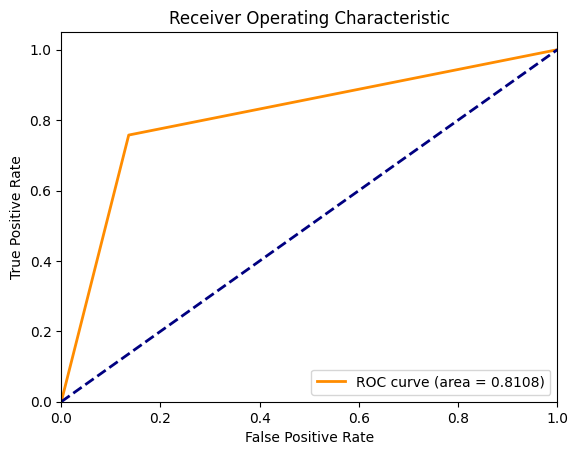

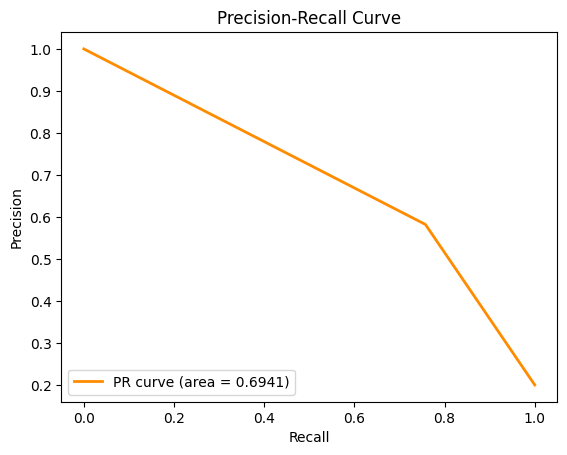

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc

# Set the model to evaluation mode
model.eval()

test_preds = []
test_targets = []

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in tqdm(test_loader_1, desc='Testing'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        
        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).cpu().numpy()
        
        test_preds.extend(predicted)
        test_targets.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_targets, test_preds)
print(f'ROC-AUC: {roc_auc:.4f}')

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_targets, test_preds)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)
print('Confusion Matrix:\n', conf_matrix)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_targets, test_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm

# Training loop setup
#Initialize metrics dictionaries
train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Training loop setup
train_losses = []
val_losses = []

current_epoch = 0  # Change this to the epoch you want to continue from
num_epochs = 30  # Set the total number of epochs you want to run

# Define early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will stop
min_delta = 0.001  # Minimum change in validation F1-score to be considered as improvement
best_val_f1_score = 0
epochs_without_improvement = 0

# Continue training for additional epochs
for epoch in range(current_epoch, num_epochs):
    model.train()
    running_train_loss = 0.0
    train_preds = []
    train_targets = []

    # Training loop with a progress bar
    for images, labels in tqdm(train_loader_2, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
        train_preds.extend(predicted)
        train_targets.extend(labels.cpu().numpy())

    # Calculate and print the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader_2)
    train_losses.append(avg_train_loss)
    
    # Calculate training metrics for this epoch
    train_accuracy = accuracy_score(train_targets, train_preds)
    train_precision = precision_score(train_targets, train_preds)
    train_recall = recall_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds)
    train_roc_auc = roc_auc_score(train_targets, train_preds)

    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(train_roc_auc)
    
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    # Validation loop with a progress bar
    with torch.no_grad():  # No need to track gradients for validation
        for images, labels in tqdm(val_loader_2, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images).view(-1)  # Reshape outputs to match labels shape
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
            running_val_loss += loss.item()

            predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
            val_preds.extend(predicted)
            val_targets.extend(labels.cpu().numpy())

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader_2)
    val_losses.append(avg_val_loss)
    
    # Calculate validation metrics for this epoch
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_precision = precision_score(val_targets, val_preds)
    val_recall = recall_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds)
    val_roc_auc = roc_auc_score(val_targets, val_preds)

    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Early stopping based on validation F1-score
    if val_f1 - min_delta > best_val_f1_score:
        best_val_f1_score = val_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'Adam_weights_ss2.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

    # Print loss and accuracy for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Metrics: Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, ROC AUC: {train_roc_auc:.4f}')
    print(f'Validation Metrics: Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')
    print('Confusion Matrix:\n', confusion_matrix(val_targets, val_preds))

print('Finished Training')


Epoch 1/30 (Validation): 100%|██████████| 104/104 [00:16<00:00,  6.23it/s]


Epoch [1/30], Training Metrics: Loss: 0.6164, Accuracy: 0.7913, Precision: 0.8441, Recall: 0.6463, F1: 0.7321, ROC AUC: 0.7760
Validation Metrics: Loss: 0.7042, Accuracy: 0.8411, Precision: 0.5799, Recall: 0.7447, F1: 0.6521, ROC AUC: 0.8049
Confusion Matrix:
 [[4568  712]
 [ 337  983]]


Epoch 2/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.75it/s]


Epoch [2/30], Training Metrics: Loss: 0.6152, Accuracy: 0.7924, Precision: 0.8524, Recall: 0.6404, F1: 0.7313, ROC AUC: 0.7764
Validation Metrics: Loss: 0.6828, Accuracy: 0.8655, Precision: 0.6773, Recall: 0.6250, F1: 0.6501, ROC AUC: 0.7753
Confusion Matrix:
 [[4887  393]
 [ 495  825]]


Epoch 3/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.59it/s]


Epoch [3/30], Training Metrics: Loss: 0.6149, Accuracy: 0.7931, Precision: 0.8532, Recall: 0.6416, F1: 0.7324, ROC AUC: 0.7772
Validation Metrics: Loss: 0.6843, Accuracy: 0.8645, Precision: 0.6644, Recall: 0.6523, F1: 0.6583, ROC AUC: 0.7849
Confusion Matrix:
 [[4845  435]
 [ 459  861]]


Epoch 4/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.70it/s]


Epoch [4/30], Training Metrics: Loss: 0.6147, Accuracy: 0.7941, Precision: 0.8527, Recall: 0.6447, F1: 0.7343, ROC AUC: 0.7784
Validation Metrics: Loss: 0.6854, Accuracy: 0.8612, Precision: 0.6601, Recall: 0.6311, F1: 0.6452, ROC AUC: 0.7749
Confusion Matrix:
 [[4851  429]
 [ 487  833]]


Epoch 5/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.74it/s]


Epoch [5/30], Training Metrics: Loss: 0.6140, Accuracy: 0.7961, Precision: 0.8516, Recall: 0.6513, F1: 0.7381, ROC AUC: 0.7808
Validation Metrics: Loss: 0.6961, Accuracy: 0.8492, Precision: 0.6014, Recall: 0.7303, F1: 0.6596, ROC AUC: 0.8046
Confusion Matrix:
 [[4641  639]
 [ 356  964]]


Epoch 6/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.51it/s]


Epoch [6/30], Training Metrics: Loss: 0.6128, Accuracy: 0.7994, Precision: 0.8509, Recall: 0.6612, F1: 0.7441, ROC AUC: 0.7848
Validation Metrics: Loss: 0.6858, Accuracy: 0.8647, Precision: 0.6587, Recall: 0.6712, F1: 0.6649, ROC AUC: 0.7921
Confusion Matrix:
 [[4821  459]
 [ 434  886]]


Epoch 7/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.54it/s]


Epoch [7/30], Training Metrics: Loss: 0.6128, Accuracy: 0.7990, Precision: 0.8550, Recall: 0.6556, F1: 0.7421, ROC AUC: 0.7839
Validation Metrics: Loss: 0.6873, Accuracy: 0.8626, Precision: 0.6513, Recall: 0.6735, F1: 0.6622, ROC AUC: 0.7917
Confusion Matrix:
 [[4804  476]
 [ 431  889]]


Epoch 8/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.66it/s]


Epoch [8/30], Training Metrics: Loss: 0.6122, Accuracy: 0.8003, Precision: 0.8560, Recall: 0.6581, F1: 0.7441, ROC AUC: 0.7854
Validation Metrics: Loss: 0.7037, Accuracy: 0.8424, Precision: 0.5834, Recall: 0.7417, F1: 0.6531, ROC AUC: 0.8046
Confusion Matrix:
 [[4581  699]
 [ 341  979]]


Epoch 9/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.76it/s]


Epoch [9/30], Training Metrics: Loss: 0.6122, Accuracy: 0.8012, Precision: 0.8521, Recall: 0.6649, F1: 0.7470, ROC AUC: 0.7869
Validation Metrics: Loss: 0.6993, Accuracy: 0.8476, Precision: 0.5970, Recall: 0.7318, F1: 0.6576, ROC AUC: 0.8042
Confusion Matrix:
 [[4628  652]
 [ 354  966]]


Epoch 10/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.60it/s]


Epoch [10/30], Training Metrics: Loss: 0.6114, Accuracy: 0.8014, Precision: 0.8586, Recall: 0.6585, F1: 0.7453, ROC AUC: 0.7864
Validation Metrics: Loss: 0.6839, Accuracy: 0.8680, Precision: 0.6715, Recall: 0.6659, F1: 0.6687, ROC AUC: 0.7922
Confusion Matrix:
 [[4850  430]
 [ 441  879]]


Epoch 11/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.65it/s]


Epoch [11/30], Training Metrics: Loss: 0.6108, Accuracy: 0.8044, Precision: 0.8542, Recall: 0.6714, F1: 0.7519, ROC AUC: 0.7905
Validation Metrics: Loss: 0.7029, Accuracy: 0.8433, Precision: 0.5857, Recall: 0.7402, F1: 0.6539, ROC AUC: 0.8046
Confusion Matrix:
 [[4589  691]
 [ 343  977]]


Epoch 12/30 (Validation): 100%|██████████| 104/104 [00:14<00:00,  7.37it/s]


Epoch [12/30], Training Metrics: Loss: 0.6101, Accuracy: 0.8043, Precision: 0.8619, Recall: 0.6626, F1: 0.7492, ROC AUC: 0.7894
Validation Metrics: Loss: 0.6889, Accuracy: 0.8621, Precision: 0.6412, Recall: 0.7053, F1: 0.6717, ROC AUC: 0.8033
Confusion Matrix:
 [[4759  521]
 [ 389  931]]


Epoch 13/30 (Validation): 100%|██████████| 104/104 [00:14<00:00,  7.29it/s]


Epoch [13/30], Training Metrics: Loss: 0.6108, Accuracy: 0.8043, Precision: 0.8567, Recall: 0.6684, F1: 0.7509, ROC AUC: 0.7901
Validation Metrics: Loss: 0.6932, Accuracy: 0.8562, Precision: 0.6216, Recall: 0.7182, F1: 0.6664, ROC AUC: 0.8045
Confusion Matrix:
 [[4703  577]
 [ 372  948]]


Epoch 14/30 (Validation): 100%|██████████| 104/104 [00:13<00:00,  7.63it/s]


Epoch [14/30], Training Metrics: Loss: 0.6102, Accuracy: 0.8049, Precision: 0.8590, Recall: 0.6673, F1: 0.7511, ROC AUC: 0.7904
Validation Metrics: Loss: 0.6982, Accuracy: 0.8506, Precision: 0.6007, Recall: 0.7545, F1: 0.6689, ROC AUC: 0.8146
Confusion Matrix:
 [[4618  662]
 [ 324  996]]


Epoch 15/30 (Validation): 100%|██████████| 104/104 [00:14<00:00,  7.08it/s]


Epoch [15/30], Training Metrics: Loss: 0.6096, Accuracy: 0.8067, Precision: 0.8609, Recall: 0.6701, F1: 0.7537, ROC AUC: 0.7923
Validation Metrics: Loss: 0.6816, Accuracy: 0.8686, Precision: 0.6825, Recall: 0.6417, F1: 0.6615, ROC AUC: 0.7835
Confusion Matrix:
 [[4886  394]
 [ 473  847]]


Epoch 16/30 (Validation): 100%|██████████| 104/104 [00:14<00:00,  7.17it/s]


Epoch [16/30], Training Metrics: Loss: 0.6088, Accuracy: 0.8075, Precision: 0.8644, Recall: 0.6688, F1: 0.7541, ROC AUC: 0.7930
Validation Metrics: Loss: 0.6976, Accuracy: 0.8515, Precision: 0.6046, Recall: 0.7447, F1: 0.6673, ROC AUC: 0.8115
Confusion Matrix:
 [[4637  643]
 [ 337  983]]


Epoch 17/30 (Validation): 100%|██████████| 104/104 [00:19<00:00,  5.33it/s]


Early stopping after 5 epochs without improvement.
Finished Training


Testing: 100%|██████████| 104/104 [00:25<00:00,  4.07it/s]


ROC-AUC: 0.7888
Precision-Recall AUC: 0.7088
Confusion Matrix:
 [[4914  366]
 [ 466  854]]


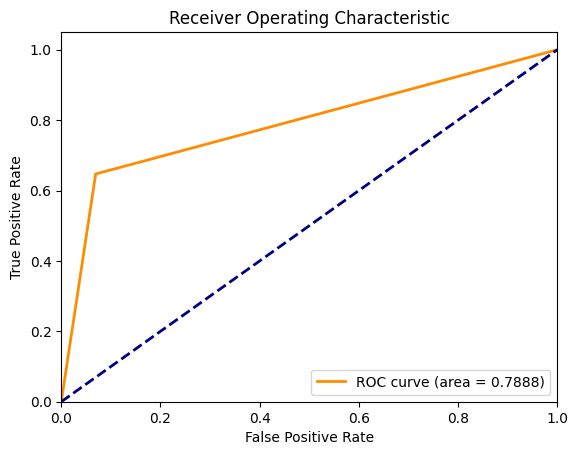

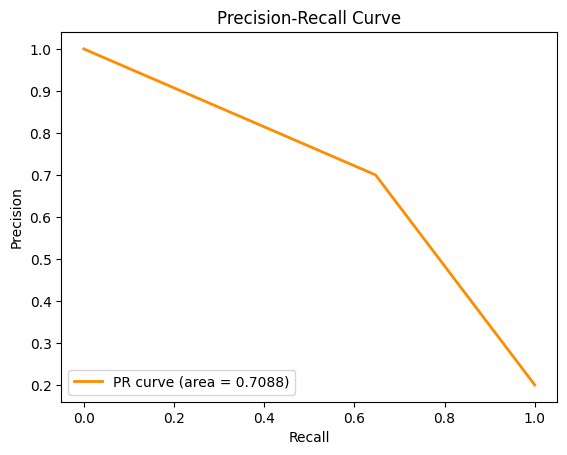

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc

# Set the model to evaluation mode
model.eval()

test_preds = []
test_targets = []

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in tqdm(test_loader_2, desc='Testing'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        
        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).cpu().numpy()
        
        test_preds.extend(predicted)
        test_targets.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_targets, test_preds)
print(f'ROC-AUC: {roc_auc:.4f}')

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_targets, test_preds)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)
print('Confusion Matrix:\n', conf_matrix)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_targets, test_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm

# Training loop setup
#Initialize metrics dictionaries
train_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

val_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Training loop setup
train_losses = []
val_losses = []

current_epoch = 0  # Change this to the epoch you want to continue from
num_epochs = 30  # Set the total number of epochs you want to run

# Define early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will stop
min_delta = 0.001  # Minimum change in validation F1-score to be considered as improvement
best_val_f1_score = 0
epochs_without_improvement = 0

# Continue training for additional epochs
for epoch in range(current_epoch, num_epochs):
    model.train()
    running_train_loss = 0.0
    train_preds = []
    train_targets = []

    # Training loop with a progress bar
    for images, labels in tqdm(train_loader_3, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
        train_preds.extend(predicted)
        train_targets.extend(labels.cpu().numpy())

    # Calculate and print the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader_3)
    train_losses.append(avg_train_loss)
    
    # Calculate training metrics for this epoch
    train_accuracy = accuracy_score(train_targets, train_preds)
    train_precision = precision_score(train_targets, train_preds)
    train_recall = recall_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds)
    train_roc_auc = roc_auc_score(train_targets, train_preds)

    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1'].append(train_f1)
    train_metrics['roc_auc'].append(train_roc_auc)
    
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    # Validation loop with a progress bar
    with torch.no_grad():  # No need to track gradients for validation
        for images, labels in tqdm(val_loader_3, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images).view(-1)  # Reshape outputs to match labels shape
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCELoss
            running_val_loss += loss.item()

            predicted = (outputs > 0.5).cpu().numpy()  # Convert probabilities to binary predictions
            val_preds.extend(predicted)
            val_targets.extend(labels.cpu().numpy())

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader_3)
    val_losses.append(avg_val_loss)
    
    # Calculate validation metrics for this epoch
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_precision = precision_score(val_targets, val_preds)
    val_recall = recall_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds)
    val_roc_auc = roc_auc_score(val_targets, val_preds)

    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1'].append(val_f1)
    val_metrics['roc_auc'].append(val_roc_auc)

    # Early stopping based on validation F1-score
    if val_f1 - min_delta > best_val_f1_score:
        best_val_f1_score = val_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'Adam_weights_ss3.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break

    # Print loss and accuracy for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Metrics: Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, ROC AUC: {train_roc_auc:.4f}')
    print(f'Validation Metrics: Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}')
    print('Confusion Matrix:\n', confusion_matrix(val_targets, val_preds))

print('Finished Training')


Epoch 1/30 (Validation): 100%|██████████| 155/155 [01:39<00:00,  1.55it/s]


Epoch [1/30], Training Metrics: Loss: 0.6704, Accuracy: 0.6412, Precision: 0.7566, Recall: 0.2755, F1: 0.4039, ROC AUC: 0.6027
Validation Metrics: Loss: 0.7273, Accuracy: 0.7954, Precision: 0.4917, Recall: 0.6874, F1: 0.5733, ROC AUC: 0.7549
Confusion Matrix:
 [[6513 1407]
 [ 619 1361]]


Epoch 2/30 (Validation): 100%|██████████| 155/155 [00:27<00:00,  5.66it/s]


Epoch [2/30], Training Metrics: Loss: 0.6374, Accuracy: 0.7441, Precision: 0.7898, Recall: 0.5726, F1: 0.6639, ROC AUC: 0.7261
Validation Metrics: Loss: 0.6853, Accuracy: 0.8522, Precision: 0.6660, Recall: 0.5237, F1: 0.5864, ROC AUC: 0.7290
Confusion Matrix:
 [[7400  520]
 [ 943 1037]]


Epoch 3/30 (Validation): 100%|██████████| 155/155 [00:22<00:00,  6.92it/s]


Epoch [3/30], Training Metrics: Loss: 0.6303, Accuracy: 0.7587, Precision: 0.8117, Recall: 0.5900, F1: 0.6833, ROC AUC: 0.7409
Validation Metrics: Loss: 0.6925, Accuracy: 0.8461, Precision: 0.6162, Recall: 0.6106, F1: 0.6134, ROC AUC: 0.7578
Confusion Matrix:
 [[7167  753]
 [ 771 1209]]


Epoch 4/30 (Validation): 100%|██████████| 155/155 [00:22<00:00,  7.03it/s]


Epoch [4/30], Training Metrics: Loss: 0.6271, Accuracy: 0.7661, Precision: 0.8187, Recall: 0.6036, F1: 0.6949, ROC AUC: 0.7490
Validation Metrics: Loss: 0.6867, Accuracy: 0.8590, Precision: 0.6516, Recall: 0.6338, F1: 0.6426, ROC AUC: 0.7746
Confusion Matrix:
 [[7249  671]
 [ 725 1255]]


Epoch 5/30 (Validation): 100%|██████████| 155/155 [00:21<00:00,  7.22it/s]


Epoch [5/30], Training Metrics: Loss: 0.6243, Accuracy: 0.7730, Precision: 0.8262, Recall: 0.6150, F1: 0.7051, ROC AUC: 0.7564
Validation Metrics: Loss: 0.6743, Accuracy: 0.8665, Precision: 0.7658, Recall: 0.4788, F1: 0.5892, ROC AUC: 0.7211
Confusion Matrix:
 [[7630  290]
 [1032  948]]


Epoch 6/30 (Validation): 100%|██████████| 155/155 [00:22<00:00,  7.03it/s]


Epoch [6/30], Training Metrics: Loss: 0.6232, Accuracy: 0.7774, Precision: 0.8275, Recall: 0.6260, F1: 0.7128, ROC AUC: 0.7614
Validation Metrics: Loss: 0.6843, Accuracy: 0.8607, Precision: 0.6641, Recall: 0.6141, F1: 0.6382, ROC AUC: 0.7682
Confusion Matrix:
 [[7305  615]
 [ 764 1216]]


Epoch 7/30 (Validation): 100%|██████████| 155/155 [00:21<00:00,  7.23it/s]


Epoch [7/30], Training Metrics: Loss: 0.6218, Accuracy: 0.7806, Precision: 0.8275, Recall: 0.6350, F1: 0.7186, ROC AUC: 0.7653
Validation Metrics: Loss: 0.6880, Accuracy: 0.8612, Precision: 0.6446, Recall: 0.6823, F1: 0.6629, ROC AUC: 0.7941
Confusion Matrix:
 [[7175  745]
 [ 629 1351]]


Epoch 8/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.57it/s]


Epoch [8/30], Training Metrics: Loss: 0.6204, Accuracy: 0.7826, Precision: 0.8354, Recall: 0.6318, F1: 0.7195, ROC AUC: 0.7667
Validation Metrics: Loss: 0.7433, Accuracy: 0.7766, Precision: 0.4653, Recall: 0.7864, F1: 0.5847, ROC AUC: 0.7802
Confusion Matrix:
 [[6131 1789]
 [ 423 1557]]


Epoch 9/30 (Validation): 100%|██████████| 155/155 [00:21<00:00,  7.24it/s]


Epoch [9/30], Training Metrics: Loss: 0.6189, Accuracy: 0.7866, Precision: 0.8349, Recall: 0.6437, F1: 0.7270, ROC AUC: 0.7716
Validation Metrics: Loss: 0.7042, Accuracy: 0.8381, Precision: 0.5729, Recall: 0.7480, F1: 0.6488, ROC AUC: 0.8043
Confusion Matrix:
 [[6816 1104]
 [ 499 1481]]


Epoch 10/30 (Validation): 100%|██████████| 155/155 [00:24<00:00,  6.38it/s]


Epoch [10/30], Training Metrics: Loss: 0.6182, Accuracy: 0.7871, Precision: 0.8426, Recall: 0.6364, F1: 0.7251, ROC AUC: 0.7713
Validation Metrics: Loss: 0.6878, Accuracy: 0.8605, Precision: 0.6385, Recall: 0.6975, F1: 0.6667, ROC AUC: 0.7994
Confusion Matrix:
 [[7138  782]
 [ 599 1381]]


Epoch 11/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.66it/s]


Epoch [11/30], Training Metrics: Loss: 0.6173, Accuracy: 0.7903, Precision: 0.8409, Recall: 0.6472, F1: 0.7314, ROC AUC: 0.7752
Validation Metrics: Loss: 0.6805, Accuracy: 0.8684, Precision: 0.6817, Recall: 0.6414, F1: 0.6609, ROC AUC: 0.7833
Confusion Matrix:
 [[7327  593]
 [ 710 1270]]


Epoch 12/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.46it/s]


Epoch [12/30], Training Metrics: Loss: 0.6164, Accuracy: 0.7920, Precision: 0.8433, Recall: 0.6493, F1: 0.7337, ROC AUC: 0.7770
Validation Metrics: Loss: 0.6848, Accuracy: 0.8671, Precision: 0.6579, Recall: 0.6985, F1: 0.6776, ROC AUC: 0.8039
Confusion Matrix:
 [[7201  719]
 [ 597 1383]]


Epoch 13/30 (Validation): 100%|██████████| 155/155 [00:19<00:00,  7.82it/s]


Epoch [13/30], Training Metrics: Loss: 0.6160, Accuracy: 0.7930, Precision: 0.8446, Recall: 0.6506, F1: 0.7350, ROC AUC: 0.7780
Validation Metrics: Loss: 0.6985, Accuracy: 0.8466, Precision: 0.5922, Recall: 0.7475, F1: 0.6609, ROC AUC: 0.8094
Confusion Matrix:
 [[6901 1019]
 [ 500 1480]]


Epoch 14/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.65it/s]


Epoch [14/30], Training Metrics: Loss: 0.6159, Accuracy: 0.7930, Precision: 0.8438, Recall: 0.6515, F1: 0.7353, ROC AUC: 0.7781
Validation Metrics: Loss: 0.6756, Accuracy: 0.8748, Precision: 0.7236, Recall: 0.6056, F1: 0.6593, ROC AUC: 0.7739
Confusion Matrix:
 [[7462  458]
 [ 781 1199]]


Epoch 15/30 (Validation): 100%|██████████| 155/155 [00:19<00:00,  7.78it/s]


Epoch [15/30], Training Metrics: Loss: 0.6148, Accuracy: 0.7952, Precision: 0.8466, Recall: 0.6546, F1: 0.7383, ROC AUC: 0.7804
Validation Metrics: Loss: 0.7016, Accuracy: 0.8406, Precision: 0.5776, Recall: 0.7556, F1: 0.6547, ROC AUC: 0.8087
Confusion Matrix:
 [[6826 1094]
 [ 484 1496]]


Epoch 16/30 (Validation): 100%|██████████| 155/155 [00:19<00:00,  7.86it/s]


Epoch [16/30], Training Metrics: Loss: 0.6145, Accuracy: 0.7948, Precision: 0.8525, Recall: 0.6470, F1: 0.7357, ROC AUC: 0.7793
Validation Metrics: Loss: 0.6959, Accuracy: 0.8510, Precision: 0.6059, Recall: 0.7298, F1: 0.6621, ROC AUC: 0.8056
Confusion Matrix:
 [[6980  940]
 [ 535 1445]]


Epoch 17/30 (Validation): 100%|██████████| 155/155 [00:19<00:00,  7.89it/s]


Epoch [17/30], Training Metrics: Loss: 0.6141, Accuracy: 0.7968, Precision: 0.8495, Recall: 0.6556, F1: 0.7401, ROC AUC: 0.7820
Validation Metrics: Loss: 0.6885, Accuracy: 0.8634, Precision: 0.6409, Recall: 0.7212, F1: 0.6787, ROC AUC: 0.8101
Confusion Matrix:
 [[7120  800]
 [ 552 1428]]


Epoch 18/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.41it/s]


Epoch [18/30], Training Metrics: Loss: 0.6131, Accuracy: 0.8000, Precision: 0.8490, Recall: 0.6650, F1: 0.7458, ROC AUC: 0.7858
Validation Metrics: Loss: 0.6899, Accuracy: 0.8571, Precision: 0.6252, Recall: 0.7126, F1: 0.6660, ROC AUC: 0.8029
Confusion Matrix:
 [[7074  846]
 [ 569 1411]]


Epoch 19/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.62it/s]


Epoch [19/30], Training Metrics: Loss: 0.6136, Accuracy: 0.7993, Precision: 0.8485, Recall: 0.6635, F1: 0.7447, ROC AUC: 0.7850
Validation Metrics: Loss: 0.7050, Accuracy: 0.8380, Precision: 0.5699, Recall: 0.7742, F1: 0.6565, ROC AUC: 0.8141
Confusion Matrix:
 [[6763 1157]
 [ 447 1533]]


Epoch 20/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.43it/s]


Epoch [20/30], Training Metrics: Loss: 0.6130, Accuracy: 0.8001, Precision: 0.8497, Recall: 0.6645, F1: 0.7458, ROC AUC: 0.7858
Validation Metrics: Loss: 0.6774, Accuracy: 0.8767, Precision: 0.6959, Recall: 0.6808, F1: 0.6883, ROC AUC: 0.8032
Confusion Matrix:
 [[7331  589]
 [ 632 1348]]


Epoch 21/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.47it/s]


Epoch [21/30], Training Metrics: Loss: 0.6119, Accuracy: 0.8020, Precision: 0.8535, Recall: 0.6654, F1: 0.7478, ROC AUC: 0.7876
Validation Metrics: Loss: 0.6882, Accuracy: 0.8642, Precision: 0.6395, Recall: 0.7364, F1: 0.6845, ROC AUC: 0.8163
Confusion Matrix:
 [[7098  822]
 [ 522 1458]]


Epoch 22/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.54it/s]


Epoch [22/30], Training Metrics: Loss: 0.6113, Accuracy: 0.8037, Precision: 0.8548, Recall: 0.6687, F1: 0.7504, ROC AUC: 0.7895
Validation Metrics: Loss: 0.6772, Accuracy: 0.8786, Precision: 0.6959, Recall: 0.6980, F1: 0.6969, ROC AUC: 0.8109
Confusion Matrix:
 [[7316  604]
 [ 598 1382]]


Epoch 23/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.59it/s]


Epoch [23/30], Training Metrics: Loss: 0.6108, Accuracy: 0.8039, Precision: 0.8573, Recall: 0.6665, F1: 0.7500, ROC AUC: 0.7895
Validation Metrics: Loss: 0.6699, Accuracy: 0.8828, Precision: 0.7638, Recall: 0.5995, F1: 0.6718, ROC AUC: 0.7766
Confusion Matrix:
 [[7553  367]
 [ 793 1187]]


Epoch 24/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.53it/s]


Epoch [24/30], Training Metrics: Loss: 0.6108, Accuracy: 0.8045, Precision: 0.8562, Recall: 0.6693, F1: 0.7513, ROC AUC: 0.7903
Validation Metrics: Loss: 0.6836, Accuracy: 0.8697, Precision: 0.6615, Recall: 0.7136, F1: 0.6866, ROC AUC: 0.8112
Confusion Matrix:
 [[7197  723]
 [ 567 1413]]


Epoch 25/30 (Validation): 100%|██████████| 155/155 [00:20<00:00,  7.63it/s]


Epoch [25/30], Training Metrics: Loss: 0.6107, Accuracy: 0.8045, Precision: 0.8564, Recall: 0.6691, F1: 0.7513, ROC AUC: 0.7902
Validation Metrics: Loss: 0.6796, Accuracy: 0.8743, Precision: 0.6816, Recall: 0.6975, F1: 0.6895, ROC AUC: 0.8080
Confusion Matrix:
 [[7275  645]
 [ 599 1381]]


Epoch 26/30 (Validation): 100%|██████████| 155/155 [00:21<00:00,  7.23it/s]


Epoch [26/30], Training Metrics: Loss: 0.6098, Accuracy: 0.8060, Precision: 0.8589, Recall: 0.6706, F1: 0.7532, ROC AUC: 0.7918
Validation Metrics: Loss: 0.6759, Accuracy: 0.8777, Precision: 0.7142, Recall: 0.6475, F1: 0.6792, ROC AUC: 0.7914
Confusion Matrix:
 [[7407  513]
 [ 698 1282]]


Epoch 27/30 (Validation): 100%|██████████| 155/155 [00:19<00:00,  7.76it/s]

Early stopping after 5 epochs without improvement.
Finished Training


/tmp/ipykernel_31/1526305744.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 155/155 [01:35<00:00

ROC-AUC: 0.8109
Precision-Recall AUC: 0.7317
Confusion Matrix:
 [[7357  563]
 [ 608 1372]]


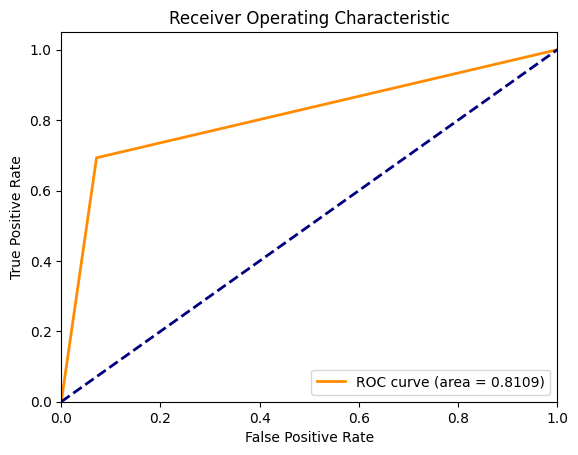

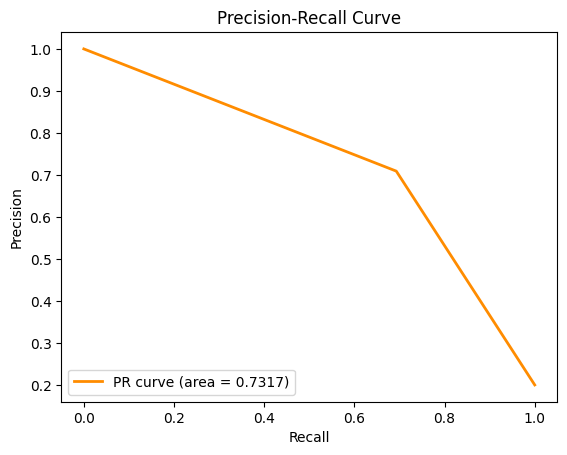

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Load the previously saved model
model_path = '/kaggle/input/hcd-clean/Adam_weights_ss3.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)  # Move model to GPU
model.eval()

test_preds = []
test_targets = []

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in tqdm(test_loader_3, desc='Testing'):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images).view(-1)  # Reshape outputs to match labels shape
        
        # Convert probabilities to binary predictions
        predicted = (outputs > 0.5).cpu().numpy()
        
        test_preds.extend(predicted)
        test_targets.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_targets, test_preds)
print(f'ROC-AUC: {roc_auc:.4f}')

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_targets, test_preds)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)
print('Confusion Matrix:\n', conf_matrix)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_targets, test_preds)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
